# 1. Data 

In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset)

### Graphs setup 
Based on the available data, you will create two graphs to model our relationships as follows: 

1. __Citation graph__: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. __Collaboration graph__: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing 

The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components. 

As a result, you will attempt to approximate that most connected component by performing the following steps: 
1. Identify the __top 10,000__ papers with the <ins>highest number of citations</ins>.
2. Then the __nodes__ of your graphs would be as follows:

   __Citation graph__: you can consider each of the papers as your nodes

   __Collaboration graph__: the authors of these papers would be your nodes
    
3. For the __edges__ of the two graphs, you would have the following cases:
   
   __Citation graph__: only consider the citation relationship between these 10,000 papers and ignore the rest.
   
   __Collaboration graph__: only consider the collaborations between the authors of these 10,000 papers and ignore the rest. 

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pickle
import os
from tqdm.notebook import tqdm

Before building the two graphs, we beed to preprocess the dataset. It is too big and it does not fit into the RAM. Moreover there are some problem with the json file format. We deal with this problem with the bash script `bash_script.sh` under the `scripts/` folder. It performs the following operations:
- split the big dataset into 24 files of 200k lineas each
- fix the json format

You can read more details in the comments inside the script.

In [8]:
# Variable to launch the preprocessing and graph building procedure

# Change to True to launch it
preprocess_and_build = True

Here we load the first split of the dataset to see how it looks like. 

In [4]:
if preprocess_and_build == True:
  df_tmp = pd.read_json('dataset/split_aa', lines=True)
  df_tmp.info()
  print(df_tmp.head(3))
  # Remove df_tmp from memory to free up space
  del df_tmp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                199999 non-null  int64 
 1   authors           199999 non-null  object
 2   title             199999 non-null  object
 3   year              199999 non-null  int64 
 4   n_citation        199999 non-null  int64 
 5   page_start        199999 non-null  object
 6   page_end          199999 non-null  object
 7   doc_type          199999 non-null  object
 8   publisher         199999 non-null  object
 9   volume            199999 non-null  object
 10  issue             199999 non-null  object
 11  doi               199999 non-null  object
 12  references        109640 non-null  object
 13  indexed_abstract  114099 non-null  object
 14  fos               197869 non-null  object
 15  venue             199999 non-null  object
 16  alias_ids         618 non-null     obj

Our stragegy to build the **citation graph** is the following:
> 1. read the columns `id`, `n_citations`, `references` from the split and merge them. <br> 
> This is the smallest number of feature that we need to build the Citation graph because it contains the paper id (that will become the nodes of the graph). the number of citation (we will need to sort and choose the 10k papers with the highest citation number) and the references to other articles
> 
> 2. add a column `split_name` that contains the name of the file  split that contains each row (below we want to read again those file and to load all the information regarding the papers in the citation graph)
>
> 3. sort the dataframe by `n_citations` in decreasing value. We will keep only the first 10k rows
>
> 4. build a list of all the edges in the citation graph using the `id` and the `references` columns
>
> 5. create the `Citation graph` where each node is the id of a paper. Later we will add the paper info as attributes. 
>
> 6. read again the file splits to save all the information about the nodes in the citation graph. <br>
> We do it in an optimized way, reading the file in chunks and saving only the relevant rows. <br>
> Then we can add all the paper info to the graph.
>
>7. save the finished citation graph in `graphs/citation-graph.pickle`

The citation graph will have 10k nodes and a maximal connected component with 9305 nodes.  

 

In [ ]:
# Here we load ONLY THE id, n_citations, references columns
# and we add the split_name column to each row

if preprocess_and_build == True:
    # Read the filepaths of the split files
    # The split file must me in the "dataset/" folder
    filepaths = [f for f in os.listdir("dataset/") if os.path.isfile(os.path.join("dataset/", f))]
    filepaths.sort()

    # Define the desired columns
    # split_name is the name of the file split where the row comes from
    cols = ['id', 'n_citation', 'references', 'split_name']

    # An empty dataframe to store the data
    df_small = pd.DataFrame(columns = cols)
    
    # Setting up the progress bar
    pbar = tqdm(total = len(filepaths))

    # Read all the split and save only the relevant columns
    for filepath in filepaths:
        
        # We read each split in chunks, to reduce memory consumption
        chunks = pd.read_json("dataset/" + filepath, lines=True, chunksize=50000, orient="records")
        for chk in chunks:
            try:
                # Add the split_name column to the chunk before concatenating
                chk['split_name'] = filepath
                
                # Concatenate the chunk to the dataframe
                df_small = pd.concat([df_small, chk[cols]], ignore_index=True)
                
            except Exception as e:
                print(chk)
        pbar.update(1)
    pbar.close()
        
    # Set the id column as index
    df_small.set_index('id', inplace=True)
    

    print(f"There are {len(df_small)} papers in the dataset")
    
    # Save the df_small dataset to file for later use
    df_small.to_csv("small_dataset.csv")
    
# # Uncomment the following code to load the dataset from file
# df_small = pd.read_csv("small_dataset.csv", index_col='id')

In [9]:
# # Uncomment the following code to load the dataset from file
df_small = pd.read_csv("small_dataset.csv", index_col='id')

In [10]:
df_small

,n_citation,references,split_name
id,,,
1091,1,"[2005687710, 2018037215]",split_aa
1388,1,NaN,split_aa
1674,1,"[1535888970, 1992876689, 1993710814, 203565334...",split_aa
1688,6,"[1560724230, 1986968751, 2156909104]",split_aa
5411,0,NaN,split_aa
...,...,...,...
2408388557,0,NaN,split_ax
2408415054,1,NaN,split_ax
2408417480,0,NaN,split_ax


In [11]:
# Function to handle NaN and process string to list of integers
def process_references(val):
    if isinstance(val, str):  # Check if the value is a string
        val = val.strip('[]')  # Strip brackets
        val = val.split(',')   # Split by comma
        val = [int(i) for i in val]  # Convert elements to integers
    elif pd.isna(val):  # Check if NaN
        val = []  # Assign an empty list for NaN
    return val

# Apply the function to the 'references' column
df_small['references'] = df_small['references'].apply(process_references)

In [12]:
df_small

,n_citation,references,split_name
id,,,
1091,1,"[2005687710, 2018037215]",split_aa
1388,1,[],split_aa
1674,1,"[1535888970, 1992876689, 1993710814, 203565334...",split_aa
1688,6,"[1560724230, 1986968751, 2156909104]",split_aa
5411,0,[],split_aa
...,...,...,...
2408388557,0,[],split_ax
2408415054,1,[],split_ax
2408417480,0,[],split_ax


## Building the Citation graph

Sorting the dataframe by `n_citations` in decreasing value. We will keep only the first 10k rows:

In [13]:
if preprocess_and_build == True:
  df_small['n_citation'] = df_small['n_citation'].astype(int)
  df_small = df_small.sort_values(by=['n_citation'], ascending=False).nlargest(1000000, 'n_citation')

Building the structure of the citation graph, that will be a directed and unweighted graph:

In [24]:
df_small

,n_citation,references,split_name
id,,,
2041404167,48327,[],split_ax
1639032689,44175,[],split_ax
2912565176,42437,[],split_au
2151103935,35541,"[19720318, 1541642243, 1560959218, 1676552347,...",split_ao
2911964244,34741,"[1507255258, 1580948147, 1605688901, 197584664...",split_au
...,...,...,...
2542826708,15,"[1800329471, 1855204404, 1986530040, 202687120...",split_aq
1515637975,15,"[1588594383, 1603190194, 1970231722, 209066788...",split_ab
2071911955,15,"[96307653, 254586386, 1621400550, 1993810789, ...",split_aj


In [15]:
exploded = df_small.references.explode()

In [16]:
exploded

id
2041404167           NaN
1639032689           NaN
2912565176           NaN
2151103935      19720318
2151103935    1541642243
                 ...    
2139498573    2126847554
2139498573    2144451085
2139498573    2154337851
2139498573    2157688311
2139498573    2753542457
Name: references, Length: 13499813, dtype: object

In [17]:
# Create a list of tuples with index and elements
edges_list = list(zip(exploded.index, exploded))

In [18]:
edges_list

[(2041404167, nan),
 (1639032689, nan),
 (2912565176, nan),
 (2151103935, 19720318),
 (2151103935, 1541642243),
 (2151103935, 1560959218),
 (2151103935, 1676552347),
 (2151103935, 1681491849),
 (2151103935, 1949116567),
 (2151103935, 2011891945),
 (2151103935, 2012778485),
 (2151103935, 2024668293),
 (2151103935, 2027089475),
 (2151103935, 2034501924),
 (2151103935, 2056313036),
 (2151103935, 2071866949),
 (2151103935, 2085207288),
 (2151103935, 2096077837),
 (2151103935, 2096600681),
 (2151103935, 2096680898),
 (2151103935, 2109863423),
 (2151103935, 2110826265),
 (2151103935, 2111308925),
 (2151103935, 2124087378),
 (2151103935, 2124386111),
 (2151103935, 2124404372),
 (2151103935, 2143539328),
 (2151103935, 2145713909),
 (2151103935, 2149646227),
 (2151103935, 2149814923),
 (2151103935, 2154422044),
 (2151103935, 2160835070),
 (2151103935, 2162601563),
 (2151103935, 2165497495),
 (2151103935, 2169351022),
 (2151103935, 2427881153),
 (2911964244, 1507255258),
 (2911964244, 1580948147

In [19]:
filtered_list = list(filter(lambda x: not np.isnan(x[1]), edges_list))

In [32]:
# Convert the list of tuples to a NumPy array
arr = np.array(filtered_list)

# Get the indices where the second element is in the certain list
indices = np.isin(arr[:, 1].astype(int), df_small.index.values)

# Filter the NumPy array based on the indices
filtered_tuples = arr[indices]

print(filtered_tuples)

[[2151103935   19720318]
 [2151103935 1541642243]
 [2151103935 1560959218]
 ...
 [2139498573 1867219652]
 [2139498573 2126847554]
 [2139498573 2144451085]]


In [33]:
len(filtered_tuples)

9822611

In [35]:
if preprocess_and_build == True:
  
  # Initialize an empty directed graph 
  G_citation = nx.DiGraph()
  
  # Adding the node to the graph
  print("Adding nodes..")
  G_citation.add_nodes_from(df_small.index.values)
  print("Done!")

  # Adding the edges to the graph
  print("Adding edges...")
  G_citation.add_edges_from(filtered_tuples)
  print("Done!")

  print(f"In the citation graph there are {len(G_citation.edges)} edges and {len(G_citation.nodes)} nodes")

Adding nodes..
Done!
Adding edges...
Done!
In the citation graph there are 9822611 edges and 1000000 nodes


In [36]:
# Save the citation graph to file
if preprocess_and_build == True:
    pickle.dump(G_citation, open('graphs/citation-graph-1M.pickle', 'wb'))

Below is a function to get the largest connected component of a graph. We also test it to find the biggest connected component of the citation graph.

In [20]:
def biggest_connected_component(G):
  
  # Get the length of each connected component and print the maximum
  len_conn_components = [len(c) for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)]
  max_len = len_conn_components[0]
  print(f"Size of the largest connected component: {max_len} nodes")
  
  # Save the biggest component as a subgraph
  for c in nx.connected_components(G.to_undirected()):
    if len(c) == max_len:
      S = G.subgraph(c).copy()
      break
  
  return S

if preprocess_and_build == True:
  # Get the biggest connected component
  G_citation_biggest = biggest_connected_component(G_citation)

Size of the largest connected component: 1 nodes


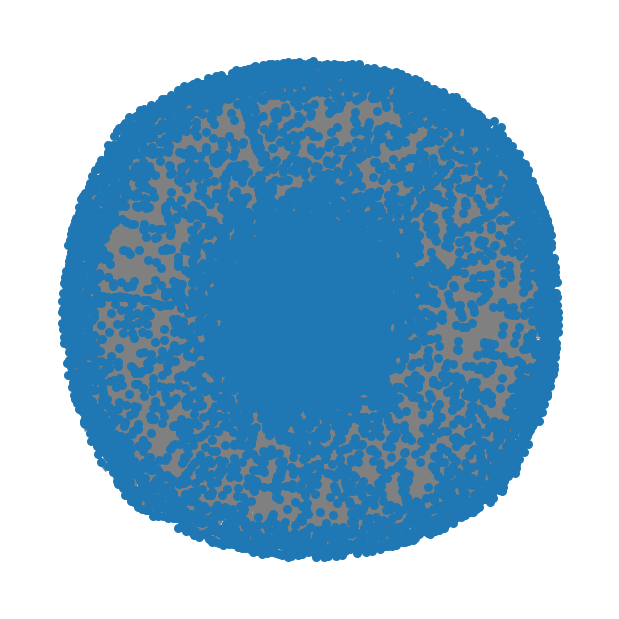

In [ ]:
if preprocess_and_build == True:
  # Draw the citation graph
  plt.figure(figsize=(6,6)) 
  pos = nx.spring_layout(G_citation)
  nx.draw(G_citation, pos, with_labels=False, node_size=30,font_size=8, edge_color='gray')

In the end this picture is not so meaningful since there are too many nodes in the graph. 

Now we can read again the file splits to save all the information about the nodes in the citation graph. First we create a dictionary with the split names as keys and the corresponding paper id as values. Then we read the split files again and we save only the info about the most important 10k papers.

In [ ]:
# Creating a dictionary with the split names as keys and the corresponding paper id as values

if preprocess_and_build == True:  
  # First of all we create an ampty dictionary with the split names as keys
  dict_split = {key: [] for key in df_small['split_name'].unique()}
  # THen we fill the dictionary with the paper ids
  for id, row in df_small.iterrows():
    dict_split[row['split_name']].append(id)
    
  # Remove df_small from memory to free up space
  del df_small
    
  # Now read again the file to save all the information about the nodes in the citation graph
  # We do it in an optimized way, reading the file in chunks and saving only the relevant rows

  # An empty dataframe to store the data
  df = pd.DataFrame()

  # Setting up the progress bar
  pbar = tqdm(total = len(dict_split.keys()))

  for filepath in dict_split.keys():
      
      # We read each split in chunks, to reduce memory consumption
      chunks = pd.read_json("dataset/" + filepath, lines=True, chunksize=10000, orient="records")
      
      for chk in chunks:
          
          # Check if all the nodes in that filepath have already been analyzed
          if dict_split[filepath] == []:
              break
          else:
              try:
                  # Save only the rows with the paper ids in the dict_split
                  chk = chk[chk.id.isin(dict_split[filepath])]
                  
                  # Concatenate the chunk to the dataframe
                  df = pd.concat([df, chk], ignore_index=True)     
                  
                  # Remove the paper ids that have already been loaded
                  dict_split[filepath] = [id for id in dict_split[filepath] if id not in chk.id.values]       
              except Exception as e:
                  # print(chk)
                  pass
      pbar.update(1)
  pbar.close()
  
  # Set the id column as index
  df.set_index('id', inplace=True)
  
  # Adding all the info about the nodes/papers to the graph
  for node in G_citation.nodes:
    nx.set_node_attributes(G_citation, {node: df.loc[node].to_dict()})
    
  # Saving the citation graph to file
  pickle.dump(G_citation, open('graphs/citation-graph.pickle', 'wb'))

100%|██████████| 24/24 [51:22<00:00, 128.43s/it]


In [ ]:
# Save the citation graph to file
if preprocess_and_build == True:
    pickle.dump(G_citation, open('graphs/citation-graph.pickle', 'wb'))
    
# # Uncomment to read the citation graph from file:
# G_citation = pickle.load(open('graphs/citation-graph.pickle', 'rb'))

## Building the Collaboration graph

Now that we have built the citation graph we can focus on building the collaboration graph. Each node will be the authors of the articles in the citation graph and each edge will represent if two authors have never collaborated. This graph will be undirected and weighted. The weight from a node A to a node B (and viceversa) will be the following:
$$weight(A, B) = \frac{1}{\text{number of collaborations between author A and B}}$$

We want authors that collaborated more times to have a smaller weight, and authors that collaborated only one time to have the maximum value of the edge 1. In this way computing a shortest path from a node A to a node B will means that those authors that have collaborated more will have the highest chance of collaborating again. This is because finding the shortest path is a problem about minimizing the path cost. 

Our strategy to build the **collaboration graph** will be as follow:
> 1. get the `id` of the 10k most important papers from the citation graph nodes
>
> 2. create an authors list with all the author information. The Collaboration Graph will have as nodes the id of the authors. We will add as nodes attributes the info about the author.
>
> 3. each edge will represent a collaboration between the two authors, i.e. nodes. Before adding the edges we need to create a DataFrame with all the possible combinations of authors and compute the number of times that they have collaborated. The dataframe will be symmetric. Then we will add the edges to the collaboration graph with the relative weights (explained in the formula above).
> 
> 4. save the finished collaboration graph in `graphs/collaboration-graph.pickle`

In [ ]:
if preprocess_and_build == True:
  # Rebuild the dataframe from the graph
  df = pd.DataFrame.from_dict(dict(G_citation.nodes(data=True)), orient='index')
  
  # First of all we create a dictionary with all the authors of the citation graph
  # The key is the author id
  authors_list = {}

  # Setting up the progress bar
  pbar = tqdm(total = df.shape[0])

  for id, paper in df.iterrows():
    for author in paper['authors']:
      if author['id'] not in authors_list.keys():
        authors_list[author['id']] = author
    pbar.update(1)
  pbar.close()
  
  # The Collaboration Graph will have as nodes the id of the authors
  G_collaboration = nx.Graph()
  G_collaboration.add_nodes_from(authors_list.keys())

  # Then we will append as attributes the information about the authors
  # Adding the authors information as attributes
  for id,  info in authors_list.items():
    nx.set_node_attributes(G_collaboration, {id: info})

100%|██████████| 10000/10000 [00:03<00:00, 3016.66it/s]


Before adding the edges we need to create a DataFrame with all the possible combinations of authors and compute the number of times that they have collaborated:

In [ ]:
if preprocess_and_build == True:
  # We initialize the DataFrame with all zeros
  df_collaboration = pd.DataFrame(data = 0, columns = authors_list.keys(), index = authors_list.keys(), dtype = int)

  # Now fill the colaboration dataframe with the number of collaborations
  # The matrix will be symmetric

  df_collaboration = pd.DataFrame(data = 0, columns = authors_list.keys(), index = authors_list.keys(), dtype = int)

  # Setting up the progress bar
  pbar = tqdm(total = df.shape[0])

  for id, paper in df.iterrows():
    for author in paper['authors']:
      for coauthor in paper['authors']:
        if author['id'] != coauthor['id']:
          df_collaboration.loc[author['id'], coauthor['id']] += 1
    pbar.update(1)
  pbar.close()


  # Add the edges to the graphs with the relative weights
  # Setting up the progress bar
  pbar = tqdm(total = df_collaboration.shape[0])

  for id, row in df_collaboration.iterrows():
    for col, value in row.items():
      if value != 0:
        # The weights of the edges will be one divided by the number of times two authors have collaborated
        G_collaboration.add_edge(id, col, weight = 1/value)
        
    pbar.update(1)
  pbar.close()

  # Save the collaboration graph to file
  pickle.dump(G_collaboration, open('graphs/collaboration-graph.pickle', 'wb'))
  
  # # Uncomment to read the collaboration graph from file:
  # G_collaboration = pickle.load(open('graphs/collaboration-graph.pickle', 'rb'))

100%|██████████| 21099/21099 [10:18<00:00, 34.10it/s]


Some little statistics about the collaboration graph, such that the number of total collaborations:

In [ ]:
if preprocess_and_build == True:
  # Number of total collaborations
  # Since the matrix is simmetrical and the collaboration is a bidirectional relationship
  # we have to divide by 2
  tot_collab = df_collaboration[df_collaboration > 0].count().sum() / 2
  print(f"There are {tot_collab} collaborations in the graph")

There are 121378.0 collaborations in the graph


Now we want to know how many nodes has the biggest connected component of the collaboration graph. 

In [ ]:
if preprocess_and_build == True:
  # Get the biggest connected component
  G_collab_biggest = biggest_connected_component(G_collaboration)

Size of the largest connected component: 9231 nodes


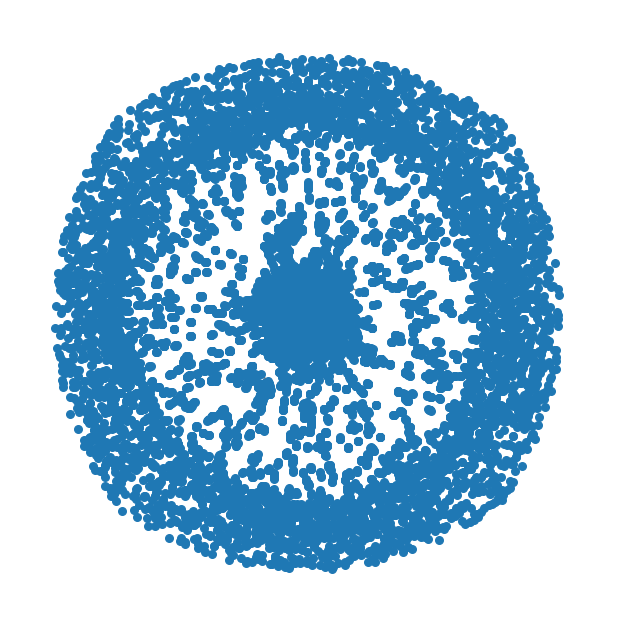

In [ ]:
if preprocess_and_build == True:
  # Draw the collaboration graph
  plt.figure(figsize=(6,6)) 
  pos = nx.spring_layout(G_collaboration)
  nx.draw(G_collaboration, pos, with_labels=False, node_size=30,font_size=8, edge_color='gray')

In the end this picture is not so meaningful since there are too many nodes in the graph. 

# 2. Controlling system

Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in. 

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality). 

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities. 

## 2.1. Backend Implementation
This section describes what each of the functionalities should be. 

### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below. 

Input: 
- The graph
- The name of the graph

Output: 
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

### Functionality 2 - Nodes' contribution 
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements. 

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output: 
- The centrality of the node, calculated based on the following centrality measurements:
   - [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
   - [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
   - [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
   - DegreeCentrality
     
### Functionality 3 - Shortest ordered walk  

Input:  
- The graph data 
- A sequence of authors\_a = [a\_2, ..., a\_{n-1}]
- Initial node a\_1 and an end node a\_n
- $N$: denoting the top $N$ authors whose data should be considered
 
Output: 
- The shortest walk of collaborations you need to read to get from author a\_1 to author a\_n and the papers you need to cross to realize this walk.
 
Considerations: 
For this functionality, you must implement an algorithm that returns the shortest __walk__ that goes from node a\_j to a\_n, which visits **in order** the nodes in _a_. The choice of a\_j and a\_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way) 

__Important Notes:__
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in _a_ are reachable from a\_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node _a\_i_ more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct. 

### Functionality 4 - Disconnecting Graphs

Input: 
- The graph data 
- authorA: a paper to which will relate sub-graph G\_a
- authorB: a paper to which will relate sub-graph G\_b
- $N$: denoting the top $N$ authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G\_a and G\_b.

### Functionality 5 - Extracting Communities

Input: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

Important Notes:  
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

## 2.2. Frontend Implementation 
This section describes how the final results for each functionality implemented in the backend section should be presented to the user. 

Please run __at least one query for each functionality__ in the final version of the notebook and __comment on the results__. 

### Visualization 1 - Visualize graph features 
We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

 - A table containing the following general information about the graph: 
      - Number of nodes in the graph
      - Number of the edges in the graph 
      - Density of the graph
      - Average degree of the graph
      - Whether the network is sparse or dense 
 - A table that lists the graph's hubs
 - A plot depicting the distribution of the citations received by papers (Citation graph)
 - A plot depicting the distribution of the given citations by papers (Citation graph) 
 - A plot depicting the number of collaborations of the author (Collaboration graph)

__Note:__ You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots. 


 ### Visualization 2 - Visualize the node's contribution
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

   - A table containing the node's centrality value based on the four centrality measurements

 ### Visualization 3 - Visualize the shortest-ordered route 
 We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:
 - Print the papers needed to be crossed in the shortest walk in order 
 - Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)
 
 ### Visualization 4 - Visualize the disconnected graph 
 We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:
 - Print the number of the links that should be disconnected 
 - Plot the original graph 
 - Plot the graph after removing the links and identify the two nodes

### Visualization 5 - Visualize the communities
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

 - Print the number of links that should be removed to have the communities
 - A table depicting the communities and the papers that belong to each community
 - Plot the original graph 
 - Plot the graph showing the communities in the network 
 - Plot the final graph and identify the community/communities of Paper_1 and Paper_2

In [ ]:
# TODO

# 3. Bonus - PageRank on MapReduce 

__IMPORTANT:__ This is a bonus step, so it's <ins>not mandatory</ins>. You can get the maximum score without doing this. We will consider this, __only if__ the rest of the homework has been completed.

Working with big data has become increasingly important in the modern era as the volume and complexity of data generated grows. In this part, we ask you to __implement the PageRank algorithm using MapReduce paradigm__ to compute the <ins>importance of papers</ins> based on the citation relationship. 

Since a large dataset is required to fully understand the power of this paradigm, when creating the Citation graph, consider the __top 1,000,000 papers__ that have received the most citations; then, make the graph exclusively for those papers. 

__Hint:__ 
[Here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S15/cs5140/L24-MR+PR.pdf) are __two approaches__ to implement the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.

In [2]:
G_citation = pickle.load(open('graphs/citation-graph-1M.pickle', 'rb'))

G_citation

In [3]:
# Generate or load a NetworkX graph (Replace this with your actual graph)
nx_graph = G_citation

In [5]:
import os
# set spark environment

os.environ['PYSPARK_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"
os.environ['PYSPARK_DRIVER_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"

In [6]:
import networkx as nx
from pyspark import SparkContext

# Initialize SparkContext
sc = SparkContext("local", "PageRank")

# Convert NetworkX graph to RDD
edges = sc.parallelize(nx_graph.edges())

# Construct RDD where each node has outgoing edges
links = edges.groupByKey().mapValues(list)

# Number of iterations for PageRank calculation
iterations = 10

# Initial PageRank values
page_ranks = links.map(lambda x: (x[0], 1.0/len(nx_graph.nodes)))

# Perform PageRank iterations
for _ in tqdm(range(iterations)):
    # Calculate contributions to each link
    contributions = links.join(page_ranks).flatMap(lambda x: [(dest, x[1][1] / len(x[1][0])) for dest in x[1][0]])

    # Update PageRank values
    old_page_ranks = page_ranks
    page_ranks = contributions.reduceByKey(lambda x, y: x + y).mapValues(lambda x: 0.15/len(nx_graph.nodes) + 0.85 * x)

    # check if reached convergence
    if old_page_ranks == page_ranks:
        print("Found convergence!")
        break

# Collect final PageRank values
final_page_ranks = page_ranks.collect()

somma = 0
for elem in final_page_ranks:
    somma += elem[1]

for i in range(len(final_page_ranks)):
   final_page_ranks[i] = (final_page_ranks[i][0], final_page_ranks[i][1] / somma)

print(final_page_ranks)

# Stop SparkContext
sc.stop()


  0%|          | 0/10 [00:00<?, ?it/s]

Py4JJavaError: An error occurred while calling o14.broadcast.
: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:64)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:363)
	at org.apache.spark.broadcast.TorrentBroadcast$.$anonfun$blockifyObject$1(TorrentBroadcast.scala:360)
	at org.apache.spark.broadcast.TorrentBroadcast$.$anonfun$blockifyObject$1$adapted(TorrentBroadcast.scala:360)
	at org.apache.spark.broadcast.TorrentBroadcast$$$Lambda$1085/0x00000008012795d0.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.write(ObjectOutputStream.java:1872)
	at java.base/java.io.ObjectOutputStream.write(ObjectOutputStream.java:718)
	at org.apache.spark.util.Utils$.$anonfun$copyStream$1(Utils.scala:272)
	at org.apache.spark.util.Utils$$$Lambda$1045/0x000000080125e1d8.apply$mcJ$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.util.Utils$.copyStream(Utils.scala:279)
	at org.apache.spark.api.python.PythonBroadcast.$anonfun$writeObject$1(PythonRDD.scala:772)
	at org.apache.spark.api.python.PythonBroadcast$$Lambda$1090/0x00000008012805b0.apply$mcJ$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.api.python.PythonBroadcast.writeObject(PythonRDD.scala:768)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1201)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1526)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1448)


In [ ]:
result_dict = {key: value for key, value in final_page_ranks}
result_dict

{1659541576: 0.00011769051784824663,
 1967140769: 0.00016451724643160544,
 2124199440: 9.341237188051425e-05,
 2151135734: 0.0004153230686010322,
 2123820820: 0.00018869362567281795,
 2912934387: 0.0009743809688024799,
 2115937516: 0.00011726478875552518,
 2041404167: 0.005997951567677177,
 2158809862: 8.967540954942597e-05,
 2014550373: 0.00018089707575763092,
 2148251644: 0.000525321075972487,
 2131415946: 0.00021997831949780046,
 1753482797: 0.00015627473099302094,
 1993882792: 0.00018459626091694333,
 1992709202: 0.00013629743984572732,
 2110381504: 0.001482505073868269,
 1673310716: 0.00014210073391016166,
 1487583988: 0.00020561651075916846,
 1799366690: 0.00014807138777363124,
 2949605076: 7.989412754876471e-05,
 2148726987: 7.044000626296792e-05,
 2128272608: 0.0005228862931893351,
 1555993967: 6.807025581024903e-05,
 1578959085: 0.00017227091419669602,
 1620204465: 0.00014612628616937948,
 1597755753: 0.00041768259213427483,
 2079735306: 0.0001325919367303466,
 1527575280: 9.2

In [ ]:
sum(result_dict.values())

0.9999999999999966

In [39]:
# Apply PageRank algorithm
pagerank_scores = nx.pagerank(nx_graph, max_iter = 10)

pagerank_scores

{2041404167: 0.000493777981902121,
 1639032689: 0.0007704854244456445,
 2912565176: 2.3630560000006877e-07,
 2151103935: 2.3630560000006877e-07,
 2911964244: 2.3630560000006877e-07,
 1973948212: 8.636690906616132e-05,
 2153635508: 2.3630560000006877e-07,
 2156909104: 2.3630560000006877e-07,
 1791587663: 0.00020749657179574706,
 2119821739: 0.00024159838005372532,
 1995875735: 0.0002775802540696624,
 2103441770: 7.211286025963381e-05,
 2126105956: 0.00017790693432590305,
 2146058063: 1.4156377158558473e-05,
 2108234281: 7.882452013245675e-05,
 2145023731: 0.00025586945122800135,
 2161969291: 2.3630560000006877e-07,
 2171074980: 2.3630560000006877e-07,
 1880262756: 0.0002128796539642267,
 2137015675: 1.9524114567981385e-05,
 2082928585: 5.443488781402001e-06,
 1686810756: 0.00016326523871462855,
 1522301498: 0.00016863535576753453,
 2133665775: 0.00015041370981567253,
 2161444534: 2.3630560000006877e-07,
 2121863487: 0.00022510223914065712,
 2132629607: 3.090985719852049e-05,
 2011039300

In [40]:
sum(pagerank_scores.values())

0.9999999999941884

In [ ]:
def calculate_mse(dict1, dict2):
    keys = set(dict1.keys()) | set(dict2.keys())  # Union of keys from both dictionaries

    squared_diff_sum = 0

    for key in keys:
        val1 = dict1.get(key, 0)  # Get value from dict1, default to 0 if key not present
        val2 = dict2.get(key, 0)  # Get value from dict2, default to 0 if key not present

        squared_diff_sum += (val1 - val2) ** 2

    mse = squared_diff_sum / len(keys)
    return mse

In [ ]:
mse = calculate_mse(result_dict, pagerank_scores)
print(f"MSE between dict1 and dict2: {mse}")

MSE between dict1 and dict2: 5.6778520339842e-09


In [ ]:
# TODO

# 4. Command Line Question (CLQ)

In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted** graph that you have previously created: **Citation graph**: 

1. Is there any node that acts as an important "connector" between the different parts of the graph?
2. How does the degree of citation vary among the graph nodes? 
3. What is the average length of the shortest path among nodes?

__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

In [ ]:
# TODO

# 5. Algorithmic Questions (AQ)

### Part A
A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best $M$ athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best $M$ athletes from a pool of $N$ candidates. Each athlete is uniquely identified by a number from 1 to $N$ and possesses a set of $S$ sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.

Note: Assigning an athlete to a role not listed in their skills is possible. In that case, that athlete's contribution to the global score will be 0.

__Input__
The input consists of $2 + N(S + 1)$ lines:
- Line 1: the numbers $N, M,$ and $S$, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of $M$ space-separated skill names.
- Lines 3, . . . , $N(S + 1) + 2$: every group of $S + 1$ lines is formatted as follows:
  - Line 1: the unique id of the athlete.
  - Lines 2, . . . , $S + 1$: one skill name and the corresponding skill score, separated by a space.

__Output__
Print the maximum global score that can be achieved with the available athletes.

__Input 1__
```
14 10 1 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
```
__Output 1__
```
370
```
---
__Input 2__
```
14 10 2 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
HCK 12
2
ATH 14
VOL 1
3
HCK 82
ATH 30
4
HCK 9
SWM 27
5
FTB 90
HCK 50
6
ATH 52
RGB 80
7
HCK 95
SWM 11
8
TEN 85
RGB 7
9
RGB 46
SWM 30
10
SWM 16
BSK 12
11
VOL 32
HCK 40
12
SOC 41
FTB 12
13
SWM 59
TEN 82
14
SWM 34
VOL 20
```
__Output 2__
```
399
```
__Your job__:
1. Implement an algorithm to solve the described mentioned problem. 

2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the <ins>two differ</ins>, which one is right? (why?)
   
4. If you algorithm has exponential time complexity, can you provide a __polynomial-time version__? 

5. If $S=1$, how does the __time complexity__ of an optimal algorithm to solve this problem change?

### Part B

The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills $T$, our goal is to find a set of individuals $X' \subseteq X$ , such that every required skill in $T$ is exhibited by at least one individual in $X'$. Additionally, the members of team $X'$ should have low effort to work together i.e. all the members of the team $X'$ work well with each other.

This problem can be easily visualised with graphs: we define an undirected weighted graph $G=(V,E)$ where every element $x_i \in X$ has a corresponding node $v_i \in V$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V' \subseteq V$ such that $T \cap \cup_{v_i\in V'} S_{v_i}$ where $S_{v_i} =$ {set of skills of member $x_i$ corresponding to the vertex $v_i$}. The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_c(V')$.
The effort to work together $E_c(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

__Your job__:
1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution ?

In [ ]:
# TODO